In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
# from scipy import stats
# import missingno as msno
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import warnings
# pd.options.mode.chained_assignment = None
# warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn import preprocessing as skp 
# from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
import xgboost as xg
from sklearn.linear_model import LogisticRegression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Kaggle's Bike Sharing Demand 

## Overview

In this project several techniques were used to achive an RMSLE score of 0.276

Actions taken:
* Datetime was breaked into several time measures
* Fractions were rounded and scaled
* Gridsearch was used (over and over) to optimize XGBoost based XGRegressor


## Introduction

### Original Features
- datetime - hourly date + timestamp  
- season - 
    - 1 = spring
    - 2 = summer
    - 3 = fall 
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

# Summary

## 1. EDA
* Histogram the data
* Create feature correlation heatmap
* Test increase demand year-over-year, month-over-month

## 2. Feature Engineering / Data Manipulation
* Break Datetime into time measures: Year, Month, Day, Weekday, Hour
* Round fraction columns: Humidity, Windspeed, Temp, Atemp
* Remove outliers from Windspeed
* Apply Log(x+1) on the target column (Count)
* Scaling of numeric variables using various scalers

## 3. Execution
* Improve XGBoost model using gridserachCV

## 4. Validation
* RMSLE function (updated to match the log1p manipulation)
* Cross Validation

## 5. Ideas that didn't improve the model
* Create dummy variables for hours
* Seperate data to casual and registered (single column target)
* Bin hours into parts of day
* Remove outliers from Humidity

## 6. Preparing competition submition 


### Resources and guides
our challange:
* https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/
* https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile
* https://www.kaggle.com/miteshyadav/comprehensive-eda-with-xgboost-top-10-percentile


How to use XGBoost:
* For Dummies - https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
* http://nbviewer.jupyter.org/github/jmsteinw/Notebooks/blob/master/XG_Boost_NB.ipynb
* https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
* https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Modeling using Seaborn:
* https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/

Trasnformers for inbalanced data:
* http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html


# 1. EDA

## 1.1 Get the data



In [4]:
ods_bike_raw = pd.read_csv('C:\\Users\\Roy\\Dropbox\\GitHub\\Final Project\\source_files\\train.csv')
# ods_bike_raw = pd.read_csv('C:\\Users\\roy.leiser\\Dropbox\\GitHub\\Final Project\\source_files\\train.csv')
ods_bike = ods_bike_raw.copy()
ods_bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
target_columns = ['casual', 'registered', 'count']

## 1.2 Data Visualization and Analysis

Text(0.5,0.98,'temp, atemp, humidity, windspeed should be scaled')

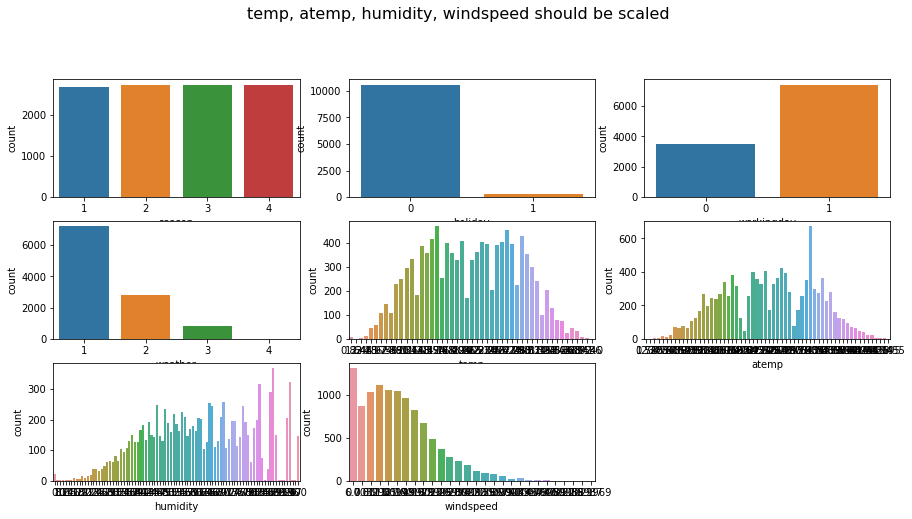

In [6]:
ods_bike_columns = ['season', 'holiday', 'workingday', 'weather', 'temp',
                    'atemp', 'humidity', 'windspeed']

plt.subplots(figsize=(15,10))
for x in range(len(ods_bike_columns)):
    plt.subplot(4,3,x+1)
    sns.countplot(ods_bike_columns[x],data=ods_bike) 

plt.suptitle('temp, atemp, humidity, windspeed should be scaled',fontsize=16)

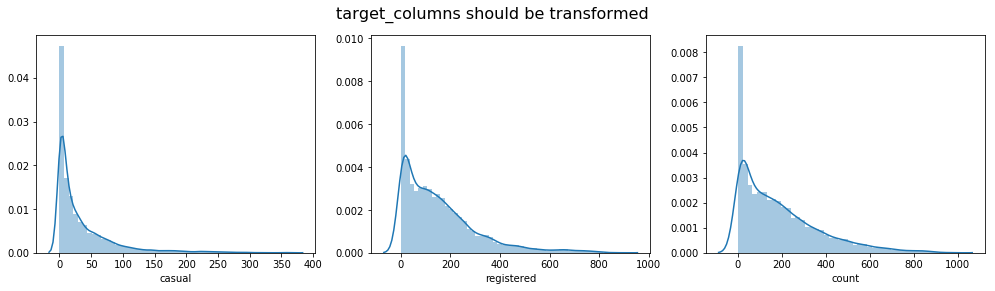

In [7]:
plt.subplots(figsize=(17,4))
plt.suptitle('target_columns should be transformed ',fontsize=16)
for i in range(len(target_columns)):
    plt.subplot(1,3,i+1)
    sns.distplot(ods_bike[target_columns[i]])


Text(0.5,0.98,'humidity and windspeed outliers should be removed')

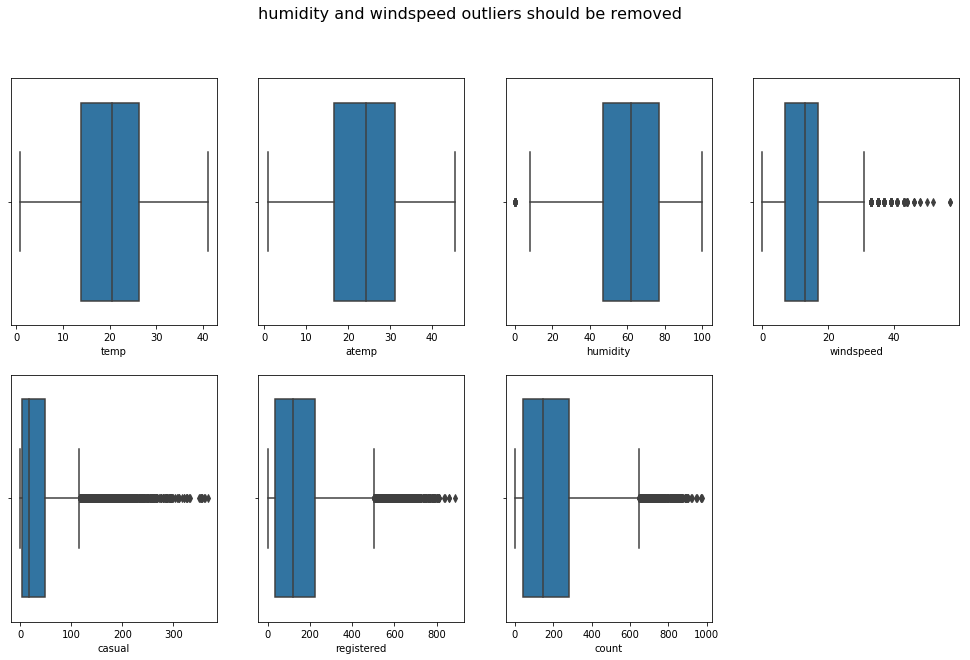

In [8]:
ods_bike_columns = ['temp','atemp', 'humidity', 'windspeed','casual', 'registered', 'count']

plt.subplots(figsize=(17,10))
for x in range(len(ods_bike_columns)):
    plt.subplot(2,4,x+1)
    sns.boxplot(ods_bike_columns[x],data=ods_bike) 
plt.suptitle('humidity and windspeed outliers should be removed',fontsize=16)

Text(0.5,0.98,'Should be re-examined after data manipulation')

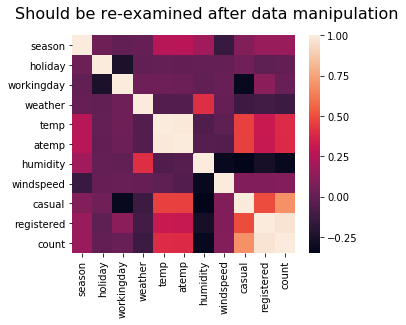

In [9]:
plt.subplots(figsize=(5,4))
corr = ods_bike.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.suptitle('Should be re-examined after data manipulation',fontsize=16)

# 2. Feature Engineering 



## 2.1 Creating Manipulation Functions

In [10]:
def round_fractions(data):
    data['atemp_round'] = data['atemp'].apply(round)
    data['temp_round'] = data['temp'].apply(round)
    data['windspeed_round'] = data['windspeed'].apply(round)
    data['humidity'] = data['humidity'].apply(round)

In [11]:
def add_time_measures(df):
#     Convert df.datetime to datetime:
    try:
        df['datetime']=df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    except TypeError:
        pass
#     add various time measures:
    df['year'] = df['datetime'].apply(lambda x: x.date().year)
    df['month'] = df['datetime'].apply(lambda x: x.date().month)
    df['weekday'] = df['datetime'].apply(lambda x: x.date().weekday())
    df['day'] = df['datetime'].apply(lambda x: x.date().day)
    df['hour'] = df['datetime'].apply(lambda x: x.time().hour)   

In [12]:
def drop_redundent_fields(df):
    del df['temp']
    del df['atemp']
    del df['temp_round']    
#     del df['atemp_round']        
    del df['windspeed']
#     del df['windspeed_round']
    del df['season']      
    del df['holiday']
    del df['datetime']

In [13]:
def remove_windspeed_outliers(df):
        df['windspeed'] = df['windspeed'].apply(lambda x: x if x < 40 else 40)
        df['windspeed_round'] = df['windspeed_round'].apply(lambda x: x if x < 40 else 40)

In [14]:
def remove_humidity_outliers(df):
        df['humidity'] = df['humidity'].apply(lambda x: x if x > 0 else 62) #62 = mean on humidity

In [15]:
def scale_columns(original_df,scaler,cols_to_scale):
    df = original_df.copy()
    for col in cols_to_scale:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

In [16]:
def convert_year_to_single_digit(df):
    df['year'] = df['year'].apply(lambda year: year-2011)
    return df

## 2.1 Data Manipulation

In [17]:
dwh_bike = ods_bike.copy()

In [18]:
round_fractions(dwh_bike) # Convert fractions into round numbers

add_time_measures(dwh_bike) # Break datetime into Year, Month, Weekday, day(of_month), hour

remove_windspeed_outliers(dwh_bike) # Remove outliers in the windspeed column

# remove_humidity_outliers(dwh_bike) # Change humidity=0 to humidity = 62

drop_redundent_fields(dwh_bike) # Remove fields that doesn't contribute to the model

convert_year_to_single_digit(dwh_bike) # Convert year from 2011 -> 0, 2012 -> 1 

dwh_bike['count'] = dwh_bike['count'].apply(np.log1p) # apply log(X+1) on the target column

# dwh_bike['day_part'] = pd.cut(dwh_bike['hour'],[0,5,9,18,24],labels=False)
# dwh_bike = pd.get_dummies(dwh_bike,columns = ['weekday'],drop_first = True)

dwh_bike.tail()

,workingday,weather,humidity,casual,registered,count,atemp_round,windspeed_round,year,month,weekday,day,hour
10881,1,1,50,7,329,5.820083,20,26,1,12,2,19,19
10882,1,1,57,10,231,5.488938,17,15,1,12,2,19,20
10883,1,1,61,4,164,5.129899,16,15,1,12,2,19,21
10884,1,1,61,12,117,4.867534,17,6,1,12,2,19,22
10885,1,1,66,4,84,4.488636,17,9,1,12,2,19,23


In [19]:
# Scaling
scaler = MaxAbsScaler()
cols_to_scale = ['humidity','atemp_round','windspeed_round','hour']

dwh_bike = scale_columns(dwh_bike,scaler,cols_to_scale)

## 2.2 Manipilated Data Visualization and Analysis

Text(0.5,1,'Transformed "count" column')

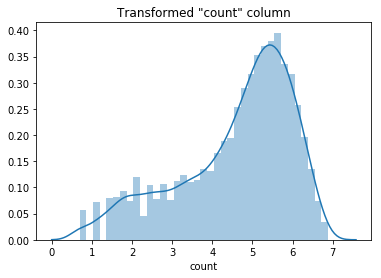

In [20]:
sns.distplot(dwh_bike['count']).set_title('Transformed "count" column')

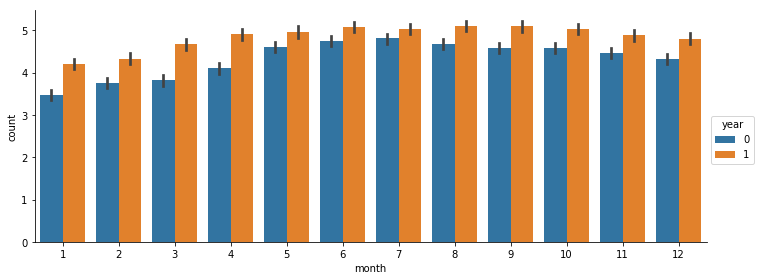

In [21]:
sns.factorplot(x="month",
               y="count",
#                col=temp_col,
               data= dwh_bike[['count','year',"month"]], 
               hue="year",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);

  

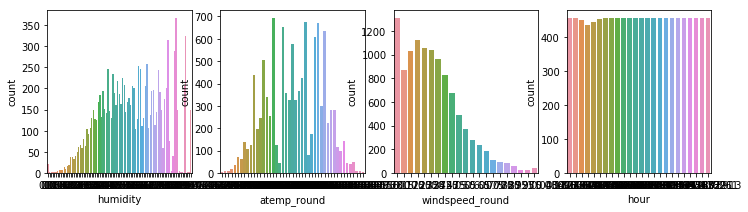

In [22]:
plt.subplots(figsize=(15,3))
for x in range(len(cols_to_scale)):
    plt.subplot(1,5,x+1)
    sns.countplot(cols_to_scale[x],data=dwh_bike,) 
    

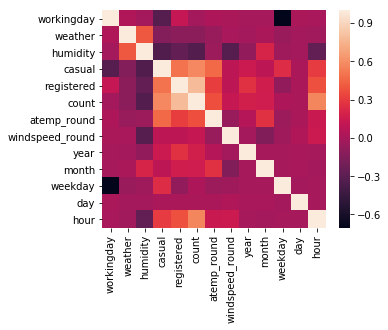

In [23]:
plt.subplots(figsize=(5,4))
dwh_corr = dwh_bike.corr()
sns.heatmap(dwh_corr, 
            xticklabels=dwh_corr.columns.values,
            yticklabels=dwh_corr.columns.values)

In [24]:
dwh_bike.tail()


,workingday,weather,humidity,casual,registered,count,atemp_round,windspeed_round,year,month,weekday,day,hour
10881,1,1,0.50,7,329,5.820083,0.444444,0.650,1,12,2,19,0.826087
10882,1,1,0.57,10,231,5.488938,0.377778,0.375,1,12,2,19,0.869565
10883,1,1,0.61,4,164,5.129899,0.355556,0.375,1,12,2,19,0.913043
10884,1,1,0.61,12,117,4.867534,0.377778,0.150,1,12,2,19,0.956522
10885,1,1,0.66,4,84,4.488636,0.377778,0.225,1,12,2,19,1.000000


# 3. Execution

## 3.1 Split

In [25]:
# Split the data
X = dwh_bike.drop(target_columns,axis=1)
y = dwh_bike['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test.head()

,workingday,weather,humidity,atemp_round,windspeed_round,year,month,weekday,day,hour
6638,1,1,0.56,0.600000,0.175,1,3,1,13,0.913043
7975,1,2,0.89,0.666667,0.475,1,6,1,12,0.695652
5915,1,1,0.55,0.511111,0.475,1,2,3,2,0.695652
8050,1,1,0.42,0.711111,0.275,1,6,4,15,0.826087
5894,1,1,0.52,0.577778,0.475,1,2,2,1,0.826087


## 3.2 Grid Search

In [26]:
# # Gridsearch to find best params:
# # hundreds of options were tested.
# params = {
#           'max_depth': [5,7,8],
#           'learning_rate':[0.1],
#           'n_estimators': [300,500],
#           'min_child_weight':[7,8,10],
#           'gamma': [0.1],
#           'subsample':[0.8],
#           'objective':['reg:linear']     
# #           'colsample_bytree':[i/10.0 for i in range(6,11)]
#           }

# xgr = xg.XGBRegressor() 
# grid = GridSearchCV(xgr, params,cv=5)

# grid.fit(X_train,y_train)
# y_pred = grid.predict(X_test)

# grid.grid_scores_, grid.best_params_, grid.best_score_

## 3.3 Model Fit

In [27]:
xgr_best = xg.XGBRegressor(
                           max_depth=8, 
                           learning_rate=0.1, 
                           n_estimators=500, 
#                            silent=True, 
                           objective='reg:linear', 
#                          objective='count:poisson'
#                            booster='gbtree', 
#                            nthread=None, 
                           gamma=0.1, 
                           min_child_weight=5, 
#                            max_delta_step=0, 
                           subsample=0.8, 
                           colsample_bytree=1, 
#                            colsample_bylevel=1, 
#                            reg_alpha=0, 
#                            reg_lambda=1, 
#                            scale_pos_weight=1, 
#                            base_score=0.5, 
#                            random_state=0, 
#                            **grid.best_params_
                           )

In [28]:
xgr_best.fit(X_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

## 3.4 Model Predict

In [29]:
y_pred = xgr_best.predict(X_test)

# 4. Validation

In [30]:
# Cross Validation 
k = 5
scores = cross_val_score(xgr_best,X_train, y_train, cv=k)

print ("Scores : " + (k * "{:.3f} ").format(*scores))
print ("Average:", scores.mean())

Scores : 0.958 0.963 0.960 0.959 0.964 
Average: 0.960787501062


In [31]:
def rmsle(y_test, y_pred): 
    return np.sqrt(np.square(np.log(y_test + 1) - np.log(y_pred + 1)).mean())

In [32]:
rmsle(np.expm1(y_test),np.expm1(y_pred))
# rmsle((y_test),(y_pred))

0.27639306506529959

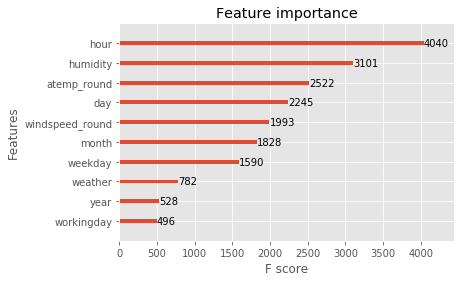

In [33]:
plt.style.use('ggplot') 
xg.plot_importance(xgr_best)   

# 5. Ideas that didn't work
### Trying the single column target approach - Seperating casual and registered

In [34]:
def convert_to_single_target_column(df):
    df_casual = df.copy()
    df_casual['is_casual'] = 1
    df_casual['target'] = df_casual['casual']
    df_casual.drop(['registered','casual','count'], axis=1, inplace=True)
    
    df_registered = df.copy()
    df_registered['is_casual'] = 0
    df_registered['target'] = df_registered['registered']
    df_registered.drop(['registered','casual','count'], axis=1, inplace=True)
    
    return pd.concat([df_casual,df_registered],ignore_index=True)
    

In [35]:
def convert_to_triple_target_column(df):
    df_casual = df[df.is_casual == 1].copy()
    df_casual['casual'] = df_casual['target']
    df_casual.drop(['target','is_casual'], axis=1, inplace=True)
    
    df_registered = df[df.is_casual == 0].copy()
    df_registered['registered'] = df_registered['target']
    df_registered.drop(['target','is_casual'], axis=1, inplace=True)
    
    df_new = pd.merge(df_casual,df_registered,on= ['datetime'])
    df_new['count'] = df_new['casual'] + df_new['registered']
     
    return df_new

In [36]:
pre_bike = ods_bike.copy()
# pre_bike.head()

In [37]:
msk = np.random.rand(len(pre_bike)) < 0.8
pre_bike_train = pre_bike[msk]
pre_bike_test = pre_bike[~msk]

In [38]:
truth = pre_bike_test[['datetime','count']] # will be used to calculate RMSLE against the final prediction.
truth.sort_values(by=['datetime'])
truth['count'] = truth['count'].apply(np.log1p)
truth.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,datetime,count
0,2011-01-01 00:00:00,2.833213
2,2011-01-01 02:00:00,3.496508
4,2011-01-01 04:00:00,0.693147
23,2011-01-01 23:00:00,3.688879
25,2011-01-02 01:00:00,2.890372


In [39]:
add_time_measures(pre_bike_train)
pre_bike_train = pre_bike_train.drop('datetime',axis=1)
pre_bike_train = convert_to_single_target_column(pre_bike_train)
pre_bike_train['target'] = pre_bike_train['target'].apply(np.log1p)

add_time_measures(pre_bike_test)
pre_bike_test = pre_bike_test.drop('datetime',axis=1)
pre_bike_test = convert_to_single_target_column(pre_bike_test)
pre_bike_test['target'] = pre_bike_test['target'].apply(np.log1p)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

In [40]:
# sns.factorplot(x="hour",
#                y="target",
# #                col=temp_col,
#                data= pre_bike_train[['target','hour','is_casual','weekday']], 
#                hue="is_casual",
#                kind="bar",
# #                col="weekday",
#                size=5, 
#                aspect=2.5);
# plt.title('Casual Demand (Daily)')

In [41]:
X_train = pre_bike_train.drop('target',axis=1)
y_train = pre_bike_train['target']
X_test = pre_bike_test.drop('target',axis=1)
y_test = pre_bike_test['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [42]:
xgr_best.fit(X_train,y_train)
y_pred = xgr_best.predict(X_test)

In [43]:
pre_bike_pred = X_test.copy()
pre_bike_pred['target'] = y_pred

In [44]:
pre_bike_pred.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,weekday,day,hour,is_casual,target
0,1,0,0,1,9.84,14.395,81,0.0000,2011,1,5,1,0,1,2.070904
1,1,0,0,1,9.02,13.635,80,0.0000,2011,1,5,1,2,1,2.050788
2,1,0,0,1,9.84,14.395,75,0.0000,2011,1,5,1,4,1,0.534927
3,1,0,0,2,18.86,22.725,88,19.9995,2011,1,5,1,23,1,2.503348
4,1,0,0,2,18.04,21.970,94,16.9979,2011,1,6,2,1,1,1.551896


In [45]:
pre_bike_pred['datetime'] = pd.to_datetime(pre_bike_pred[['year', 'month', 'day', 'hour']])
pre_bike_pred = convert_to_triple_target_column(pre_bike_pred)[['datetime','count']]

In [46]:
pre_bike_pred = pre_bike_pred.sort_values(by=['datetime'])

In [47]:
pre_bike_pred.head()

,datetime,count
0,2011-01-01 00:00:00,5.539000
1,2011-01-01 02:00:00,5.092563
2,2011-01-01 04:00:00,1.916905
3,2011-01-01 23:00:00,5.691933
4,2011-01-02 01:00:00,4.109338


In [48]:
rmsle(np.expm1(truth['count']),np.expm1(pre_bike_pred['count']))

4.2142380408815932

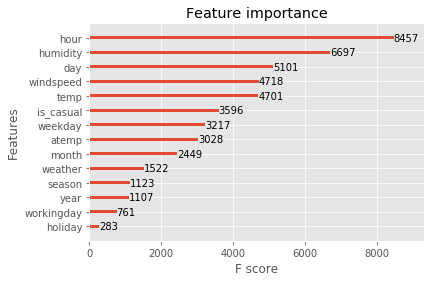

In [49]:
plt.style.use('ggplot') 
xg.plot_importance(xgr_best)

# 6. Preparing competition submition 

## 6.1 Data Preperation

In [50]:
ods_train = pd.read_csv('C:\\Users\\Roy\\Dropbox\\GitHub\\Final Project\\source_files\\train.csv')
ods_test = pd.read_csv('C:\\Users\\Roy\\Dropbox\\GitHub\\Final Project\\source_files\\test.csv')

In [51]:
target_columns = ['casual', 'registered', 'count']

In [52]:
train = ods_train.copy()
test = ods_test.copy()

In [53]:
train.shape

(10886, 12)

In [54]:
test.shape

(6493, 9)

In [55]:
# Manipulate train
round_fractions(train) # Convert fractions into round numbers
add_time_measures(train) # Break datetime into Year, Month, Weekday, day(of_month), hour
remove_windspeed_outliers(train) # Remove outliers in the windspeed column
drop_redundent_fields(train) # Remove fields that doesn't contribute to the model
convert_year_to_single_digit(train) # Convert year from 2011 -> 0, 2012 -> 1 
train['count'] = train['count'].apply(np.log1p) # apply log(X+1) on the target column

In [56]:
# Manipulate test
round_fractions(test) # Convert fractions into round numbers
add_time_measures(test) # Break datetime into Year, Month, Weekday, day(of_month), hour
remove_windspeed_outliers(test) # Remove outliers in the windspeed column
drop_redundent_fields(test) # Remove fields that doesn't contribute to the model
convert_year_to_single_digit(test) # Convert year from 2011 -> 0, 2012 -> 1 
test.tail()

,workingday,weather,humidity,atemp_round,windspeed_round,year,month,weekday,day,hour
6488,1,2,60,13,11,1,12,0,31,19
6489,1,2,60,13,11,1,12,0,31,20
6490,1,1,60,13,11,1,12,0,31,21
6491,1,1,56,14,9,1,12,0,31,22
6492,1,1,65,14,9,1,12,0,31,23


In [57]:
# Scaling
scaler = MaxAbsScaler()
cols_to_scale = ['humidity','atemp_round','windspeed_round','hour']

train = scale_columns(train,scaler,cols_to_scale)
test = scale_columns(test,scaler,cols_to_scale)
test.tail()

,workingday,weather,humidity,atemp_round,windspeed_round,year,month,weekday,day,hour
6488,1,2,0.60,0.26,0.275,1,12,0,31,0.826087
6489,1,2,0.60,0.26,0.275,1,12,0,31,0.869565
6490,1,1,0.60,0.26,0.275,1,12,0,31,0.913043
6491,1,1,0.56,0.28,0.225,1,12,0,31,0.956522
6492,1,1,0.65,0.28,0.225,1,12,0,31,1.000000


## 6.2 Execution

In [58]:
X = train.drop(target_columns,axis=1)
y = train['count']
xgr_best.fit(X,y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [59]:
test_pred = xgr_best.predict(test)
ods_test['count'] = test_pred
ods_test['count'] = ods_test['count'].apply(np.expm1)
ods_test = ods_test.drop(['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],axis=1).set_index('datetime')

ods_test.head(),ods_test.shape

(                         count
 datetime                      
 2011-01-20 00:00:00  10.790170
 2011-01-20 01:00:00   4.371822
 2011-01-20 02:00:00   3.847665
 2011-01-20 03:00:00   3.061738
 2011-01-20 04:00:00   2.132979, (6493, 1))

In [60]:
ods_test.to_csv('C:\\Users\\Roy\\Dropbox\\GitHub\\Final Project\\source_files\\final.csv')